In [39]:
from astropy.io import fits
import tayph.operations as ops
import matplotlib.pyplot as plt
import numpy as np
import tayph.system_parameters as sp
import astropy.units as u
import astropy.constants as const
import scipy.interpolate as interp
from astropy import constants as C
import narrow_spectrum
from scipy.interpolate import interp1d
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.insert(0, "/home/madeline/StarRotator")
from StarRotator import StarRotator

# Global Variables

# Systemic velocity
beta = (22.4) * 1e3 / C.c.value  # gontcharov06
doppler_shift = np.sqrt((1 + beta) / (1 - beta))

# Transit light curve parameters
RpRs = 0.074  # prinoth+24
u1 = 0.344  # pysme
u2 = 0.263

# Orbital Parameters
a_Rs = 4.6  # deline+22
inc = 84.58 * np.pi / 180  # deline+22
obl = 90.07 * np.pi / 180  # prinoth+24
vsini = 95.05e3  # prinoth+24

dp = "../masters-project/HARPS_W189/tayph_output/data/WASP-189/night"

In [16]:
FstarN_list = []
wl_list = []
Foot_list = []

In [17]:
for i in range(1, 4):
    with fits.open(dp + str(i) + "/flux_norm_0.fits") as f:
        flux = f[0].data

    with fits.open(dp + str(i) + "/wl_cor_0.fits") as f:
        wl = f[0].data
        wl_list.append(wl)

    wl_corrected = ops.vactoair(wl) * doppler_shift

    phases = sp.phase(dp + str(i))
    transit = sp.transit(dp + str(i))
    out_of_transit_idx = np.argwhere(transit == 1)
    in_transit_idx = np.argwhere(transit != 1)

    true_anom = 2 * np.pi * phases

    x_pl = a_Rs * np.sin(true_anom)
    y_pl = -a_Rs * np.cos(true_anom) * np.cos(inc)

    xp = x_pl * np.cos(obl) - y_pl * np.sin(obl)
    yp = x_pl * np.sin(obl) + y_pl * np.cos(obl)

    Foot = np.nanmean(flux[out_of_transit_idx], axis=0)
    Foot /= np.nanmean(Foot)
    Foot_list.append(Foot)
    flux_norm = flux / np.nanmean(flux, axis=1)[:, np.newaxis]

    FstarN = narrow_spectrum.compute_FstarN(
        wl_corrected,
        flux_norm,
        xp,
        yp,
        RpRs,
        u1,
        u2,
        vsini,
        in_transit_idx,
        out_of_transit_idx,
        instrument="HARPS",
    )

    FstarN_list.append(FstarN)

In [18]:
# Interpolate all spectra onto the same wavelength
wl = ops.vactoair(wl_list[0]) * doppler_shift

for i in range(1, 3):
    Foot_list[i] = interp1d(
        ops.vactoair(wl_list[i]) * doppler_shift, Foot_list[i], bounds_error=False
    )(wl)
    FstarN_list[i] = interp1d(
        ops.vactoair(wl_list[i]) * doppler_shift, FstarN_list[i], bounds_error=False
    )(wl)

In [19]:
# Estimated snr for each night
snr_list = np.array([25, 25, 32])

# Weighted average for each night
mean_oot = np.nansum(np.dstack(Foot_list)[0, :, :] * snr_list**2, axis=1) / np.nansum(
    (snr_list**2)
)

mean_FstarN = np.nansum(
    np.dstack(FstarN_list)[0, :, :] * snr_list**2, axis=1
) / np.nansum((snr_list**2))

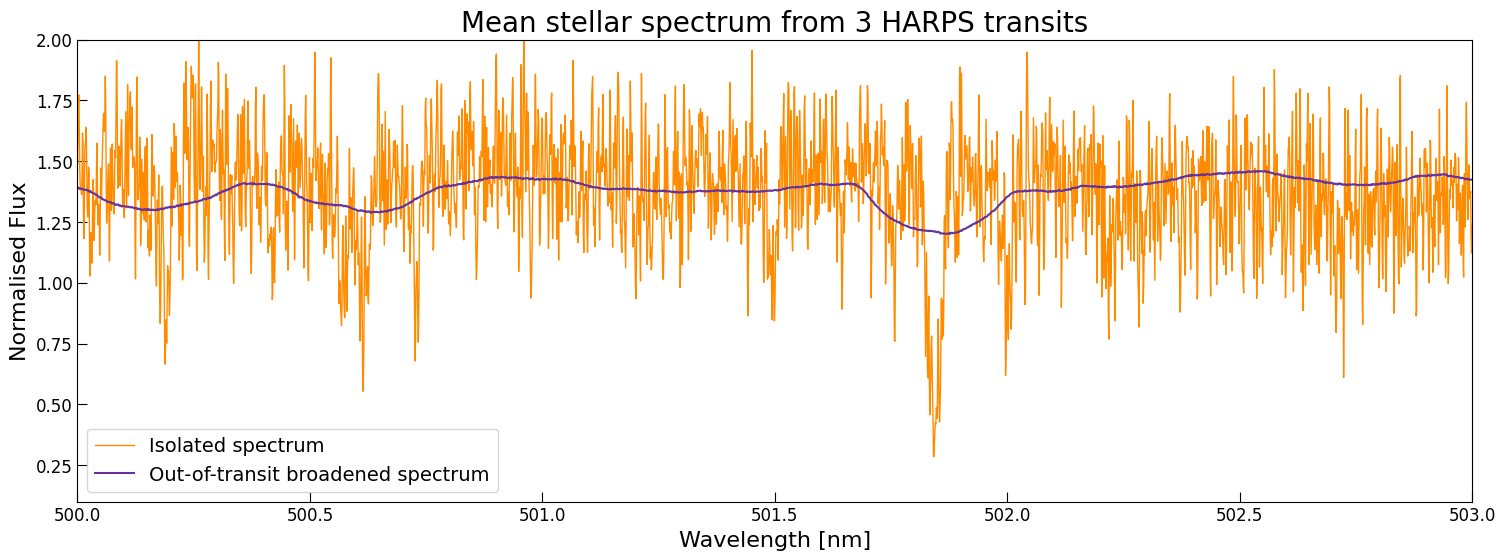

In [51]:
plt.figure(figsize=(18, 6))
plt.plot(wl, mean_FstarN, label="Isolated spectrum", color="darkorange", linewidth=1)
plt.plot(
    wl,
    mean_oot,
    label="Out-of-transit broadened spectrum",
    color="rebeccapurple",
    linewidth=1.5,
)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Normalised Flux")
plt.xlim(500, 503)
plt.ylim(0.1, 2)
plt.tick_params(direction="in", length=7)
plt.title("Mean stellar spectrum from 3 HARPS transits", fontsize=20)
plt.legend(fontsize=14)
plt.show()